# Using this Python Notebook
This Python notebook is provided to help you analyze the video images and track the motions of fat droplets. The code in this notebook uses the Python programming language and the Trackpy https://soft-matter.github.io/trackpy/v0.4.2/ package. You don't need Python programming experience to use it - we demonstrate how to use the key commands to read in your images, do the tracking, do some rudimentary processing, and output text files and graphs. You will have to make some edits and changes to this notebook to adapt it to analysing specific movies (you need to point to the right file locations, no guarantee that the locating/tracking parameters are optimised, etc)

## We recommend keeping an un-edited 'template' of this notebook, and working with copies of that template for your own analysis

The computing code and comments are organised in *cells*, which are executed one at a time.  
* To get started, please take the brief *User Interface Tour* via the *Help* menu.
* Then have a look at the *Keyboard Shortcuts* in the *Help* menu.
* Full help including tutorials is available via *Notebook Help* in the *Help* menu (probably not necessary).

You can edit the commands in the cells and re-execute them as needed. Note that some changes will require re-executing multiple cells *in the correct order*, eg if you change your image processing / feature finding parameters after your first tracking attempt, you will also need re-run the tracking-related cells or else you tracks won't change. Also note that some cells take a while to execute, so be patient when running them.

# Tracking 

By following the instructions in this document, you will be able to track the motion of the droplets in the videos you have taken. Before you start, you need to have the video saved in a single folder as a series of .tif images. If you haven't already done this use ImageJ to convert your video. 

If you are doing this lab in person and using the lab computers, then please create in `C:\Brownian_Motion\` a subfolder with your matric number, e.g. `C:\Brownian Motion\S1234567\` and store all your files (videos, images, graphs, text data etc) therein. If you are doing this on your home computer, you can put things where you like, but keeping results properly organised is important, especially as you start playing around with different processing parameters, analysis methods etc.

## Setting everything up
The code in the following cells loads all the bits of the program you need. Just put the cursor in the box and press the *Play* button (right-pointing triangle) at the top. Alternatively, you can press *Shift-Enter* on the keyboard.

<b> My note: </b> For 40x calibration movies, to 50 microns there correspond $ 155 \pm 5 $  pixels. For 100x calibration movies, to 50 microns there correspond $ 394 \pm 5 $  pixels

In [37]:
%matplotlib inline                     
import matplotlib as mpl               # plotting library will be available as 'mpl' 
import matplotlib.pyplot as plt        # graphs can be create via plt.***

# Tweak plot styles
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')
mpl.rc('axes', labelsize=16)
mpl.rc('font', size=12)


In [38]:
import numpy as np             # Numerical Python module: vectors, matrices, data analysis tools
import pandas as pd            # Pandas: more sophisticated data structures
from pandas import DataFrame, Series  
import pims as pims                   # Python Image Sequence: Load video and sequential images
import trackpy as tp           # trackpy: particle tracking module
import os as os                    # file system functions
from skimage import util, io        # Sci-kit Image, some image processing utilities

## Import Images as TIFFs
First, you need to load the images you have taken. Type the address of the folder in which you have saved the images, like the examples below. You can copy the folder name from the address bar at the top of a *File Explorer* window and paste it into the box below. 

NB: The backslash character has normally a special meaning in Python: It is used to write special characters such as a *newline*, which is then written as '\n'. To avoid this interpretation of the backslashes in Windows paths, prepend the folder string with a lowercase 'r' (for *raw* string) in front.

In [39]:
os.listdir() # returns the directory contents - I want to check my 'tiffs' folder is where I think it is

['.bash_history',
 '.ipynb_checkpoints',
 'JH_Brownian_Motion_0.ipynb',
 'JH_Brownian_Motion_Template(1) (2)-modify.ipynb',
 'JH_Brownian_Motion_Template(1) (2).ipynb',
 'jr_40x_aug2020_2drops_1_tiffs',
 'source',
 'test_results',
 'test_tiffs',
 'test_tiffs_1',
 'test_tiffs_2',
 'test_tiffs_3',
 '__MACOSX']

In [40]:
folder_loc = r'test_tiffs'; #the 'r' for 'raw string' isn't needed here, but keeping it in case 
#Import all the '.tif' images in the folder I specified
frames = pims.ImageSequence(folder_loc+ os.sep+'*.tif')

#while we are at it, also make a directory to save images/plots etc
#changing this folder name at the start is a simple way keep results from different exp / different days organised
res_dir = r'test_results'+os.sep;
os.mkdir(res_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'test_results\\'

## Look at the Images
You should check that the images load correctly. After executing the above cell, the variable `frames` should hold an array of images, and you can access every individual image as `frame[frame-number]`, i.e. `frame[0]`, `frame[1]`, `frame[2]`, ... Note that array indices in Python always start with 0. 

The code below displays frame 0, the first frame.

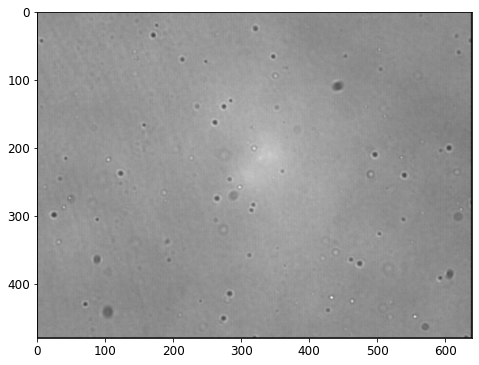

In [41]:
plt.imshow(frames[0]);

# Finding Droplets
We need to get the computer to find the droplets in the image. The routines we use are based on a paper by J. Crocker and D. Grier http://dx.doi.org/10.1006/jcis.1996.0217 and first developed for a programming language called 'IDL',  then much later impleneted in Python (https://soft-matter.github.io/trackpy/v0.4.2/introduction.html). The orginal paper has over 3000 citations, reflecting particle trackings wide application in many scientific disciplines.

The locating routine looks for bright blobs on a dark background. Depending on what your image looks like you might want to set the program to invert the image (switch black for white). The function `tp.locate()` detects 'blobs' in a single image.

We need to tell `tp.locate` what to look for, and there are numerous parameters to specifiy this. The most basic use is
```
f = tp.locate(image, <feature size in pixel>, invert=True/False)
```

Further useful, but optional, parameters are 
```
minmass    : minimum integrated brightness
maxsize    : maximum radius-of-gyration of brightness
separation : feature separation, in pixels; default is the feature diameter + 1.
threshold  : keep only features with a "strength" above the given threshold
invert     : Set to True if features are darker than background. False by default.
percentile : Features must have a peak brighter than pixels in this
             percentile. This helps eliminate spurrious peaks.
```

As you may have seen in the list of keyboard shortcuts, you can get online help for many of the Python functions: Place the cursor on a function name (in a code cell!) and press *Shift-Tab* to get a tooltip with a very brief summary of the function parameters. Every additional *Shift-Tab* gives more details; if you press this four time in a row, you'll get a separate window at the bottom with a full description of the function and its parameters.

In [42]:
# let's try to find some blobs
features0 = tp.locate(frames[0], 9 ,invert=True) #the '9' is the rough diameter of the features locate will look for
#How did I set this? I opened an image in ImageJ and manually measured the size of a dark blob
#Is this is best possible value? ¯\_(ツ)_/¯  What if I change this size? good question, ask again later. 

Now look at what we found:

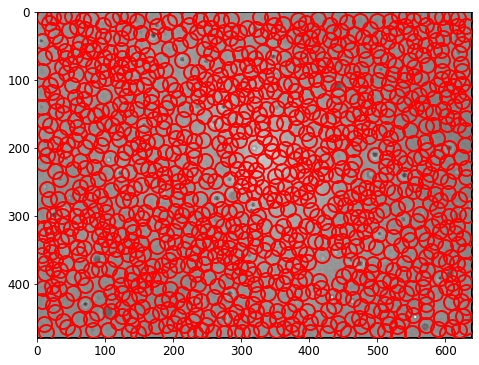

<AxesSubplot:>

In [43]:
tp.annotate(features0, frames[0])

Too many features!! Ok, this is a start... don't worry, we'll clean this up.

### Background removal

You might notice that there are some spots in your images that don't seem to move (playing with the movie in ImageJ/Fiji is usually the easiest way to pick these things out). These spots could come from dirt or smudges on the microscope lens, camera sensor, glass slide etc. We don't want to pick up these objects in our tracking. One way to remove them is to compute an average backgound image from the full image sequence, and then divide this out. This relies on the Brownian droplets moving around enough that they all get averaged out, leaving on static features, so this only works with a long enough movie. 

First we compute our average background.

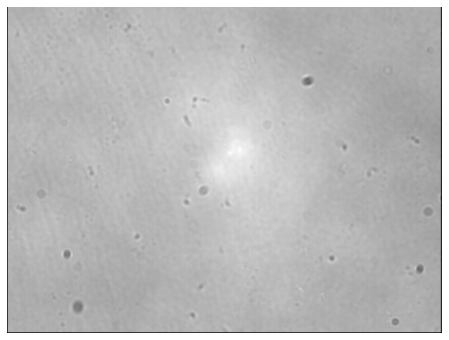

In [44]:
back = 0.0*frames[1]
N=len(frames)

for frame in frames[:]:
    back = back+frame/N;
    
plt.imshow(back); plt.axis('off');

Now we divide it out. The code below looks a little funny since it uses the PIMS pipeline routine (https://soft-matter.github.io/pims/v0.5/pipelines.html), but it basically divides each frame by our background and rescales it to be an 8-bit greyscale image.

In [45]:
@pims.pipeline
def remove_back(img,back):
    img = img/back;
    img = img/np.max(img)
    return util.img_as_ubyte(img)

newframes = remove_back(pims.ImageSequence(folder_loc+ os.sep+'*.tif'),back)

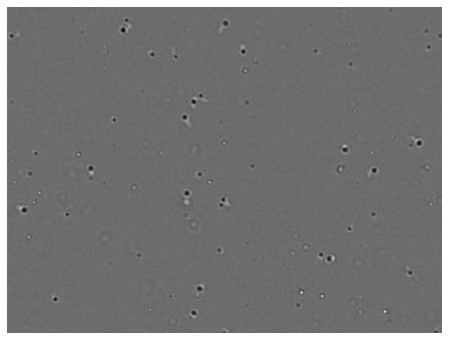

In [46]:
plt.imshow(newframes[0]); plt.axis('off');
io.imsave(res_dir+'back_divide_test.tiff', newframes[0]); #saving an image. 

this looks a bit cleaner. Would be even better with a longer movie instead of the short test images.


## Filtering Features

We can also try to improve our feature finding and tracking by filtering the features the `tp.locate` returns based on their size and brightness (or darkness when inverting). To see how this works, lets use `tp.locate` again on our new, background-removed image.

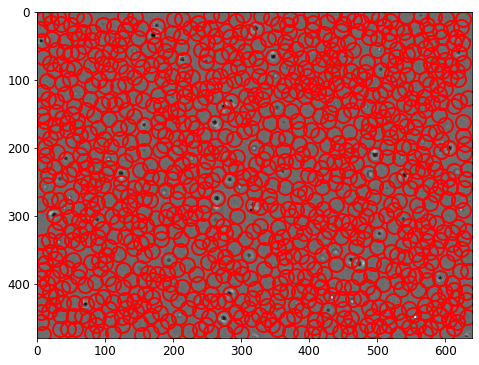

In [47]:
features1 = tp.locate(newframes[0], 9, invert=True)
tp.annotate(features1, newframes[0]);

Even though we cleaned up our image with the background divison, there are still (lots of) places where the software misinterprets some subtle variations in brightness as a feature. So we need to help the program decide which of these features are actually good particle locations. There are at least two ways of eliminating the spurious detections.

1. The features that don't matter are likely to be small and/or dim. Plot graphs of the mass (integrated brightness of a blob) and size of the blobs we found, and then set limits for the mass and size of features that should be considered particles.

1. The features that don't matter are not much brighter (or darker) than the background. Use a threshold for the difference in brightness to keep only the "strongest" features.

### Mass and Size Filters

[Text(0.5, 0, 'Mass (arb. units)'), Text(0, 0.5, 'Count')]

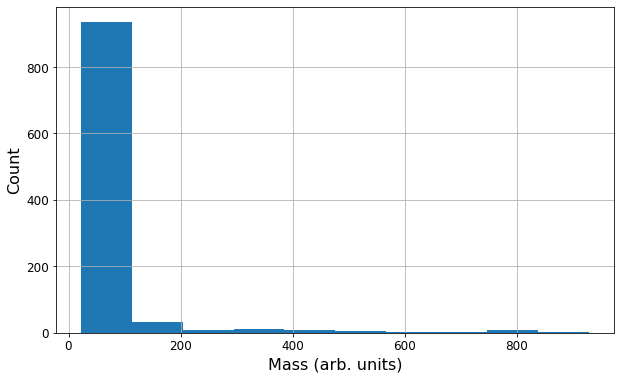

In [48]:
# let's plot a histogram of the mass distribution
ax = features1['mass'].hist()           # create the histogram
ax.set(xlabel='Mass (arb. units)', ylabel='Count')   # label the axes

Quite a lot of the blobs are very small/dim, and these seem to make up most of our spurious detections (that huge peak below about 100). When calling `tp.locate(...)` we can use the extra option `minmass=xxx`, where `xxx` is the lower mass threshold. A `minmass` of 100 to 200 may be a good start.

Unfortunately, there is no equivalent `maxmass` parameter, but we can deal with this later. Lets try this again using this minmass filter. 

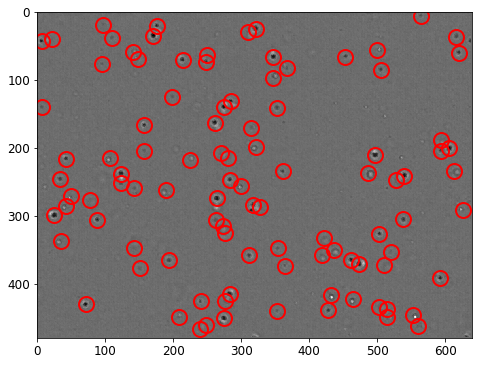

<AxesSubplot:>

In [49]:
features1 = tp.locate(newframes[0], 9, minmass=100, invert=True)
tp.annotate(features1, newframes[0])

much better. Now we can look at the size distribution.

[Text(0.5, 0, 'Size (pixel)'), Text(0, 0.5, 'Count')]

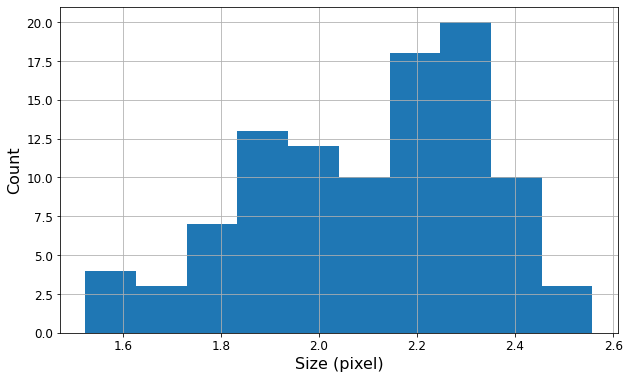

In [50]:
# plot the size distribution
ax = features1['size'].hist()           # create histograms
ax.set(xlabel='Size (pixel)', ylabel='Count')   # label the axes

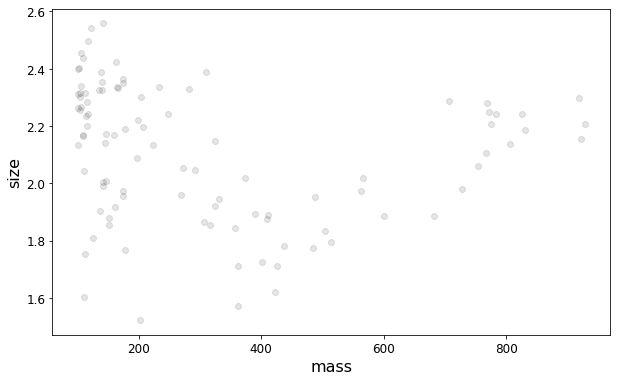

In [51]:
#plot size vs mass
tp.mass_size(features1); # convenience function -- just plots size vs. mass

In the histogram, we see a peak just below 2, and then a broad hump above 2. Plotting size vs mass, we see there are a number of 'wide and dim' objects (large size, but low mass). This is sort of odd, so maybe we should try to cut some of them out.
 We can re-run `tp.locate` using the extra `minmass` and `maxsize` parameters, eg running `features2 = tp.locate(newframes[0], 9, minmass= 100, maxsize=2.1, invert=True)`. We can also use logical expressions to filter set ranges on the size and mass, like so

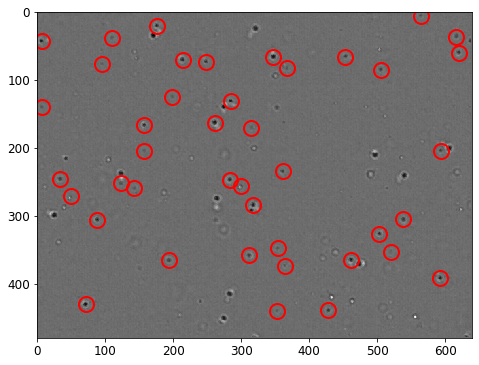

<AxesSubplot:>

In [52]:
features2 = tp.locate(newframes[0], 9, invert=True)
features2_new = features2[((features2['mass'] > 100) & (features2['size'] > 1.6) &
         (features2['mass'] < 1000)) & (features2['size'] < 2.1)]  #filter out masses /sizes I don't want
#more flexible than the built it locate parameters
tp.annotate(features2_new, newframes[0])

OK, this is looking better. Not all particles are identified, but a good selection. Lets see if we can do better.

### Brightness Threshold
Let's use the `threshold` parameter to find the strongest or clearest features.

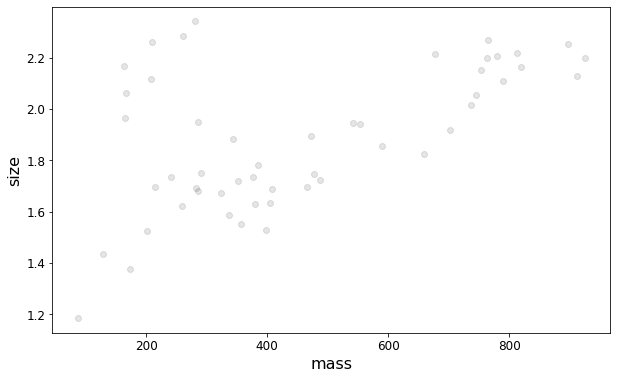

In [53]:
features3 = tp.locate(newframes[0], 9, invert=True, threshold=6)
tp.mass_size(features3);

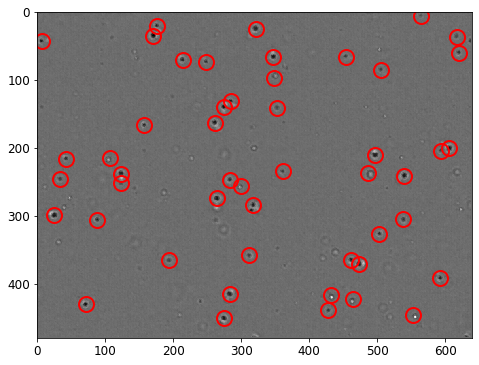

In [54]:
features3 = features3[((features3['mass'] > 100) & (features3['size'] > 1.4) &
         (features3['mass'] < 1200)) & (features3['size'] < 2.4)]
plot = tp.annotate(features3, newframes[0])
#lets save this plot
fig = plot.get_figure()
fig.savefig(res_dir+'filtered_features_test.pdf')

The threshold helped reduce the number of odd 'wide and dim' spots. This allowed us to remove those 'odd features' without completely getting rid of out large features. Optimizing these parameters takes a good deal of trial and error (no promise that the parameter used here are the best). If you are taking your own videos, you will need to adjust many (most) of these values depending on your microscope, camera, lighting etc settings.



## Processing the Whole Sequence of Frames
Once you are happy that the program has found your droplets, we need to find them in all the frames of the movie. 
The counter in the next output field will tell you how many droplets you found in each frame. Use the same parameters as you did in either of the previous steps. 

In [55]:
#this takes a while, be patient
features_all = tp.batch(newframes, 9, minmass= 50, invert=True, threshold=6) 
# put a small minmass just so the numbers aren't crazy

Frame 250: 55 features


now do the mass/size filtering. First do another size vs mass plot with all the features

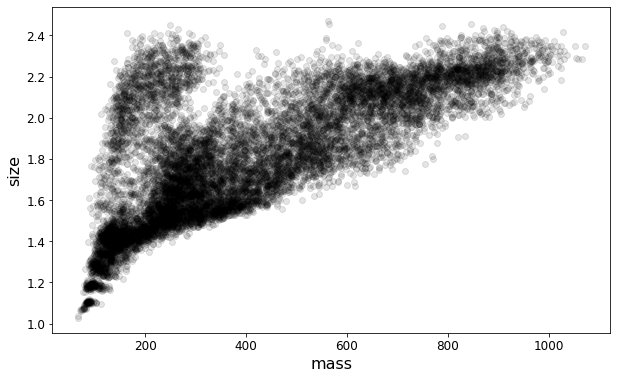

In [56]:
plot = tp.mass_size(features_all);
#lets save this plot too.
fig = plot.get_figure()
fig.savefig(res_dir+'mass_size_all.jpg') #pdf issues rendering so many points, had to live with jpg artefacts :(

Ok, most of the points look ok, but we still have some of those 'wide and dim' objects. Not so clear how to cleanly cut them out (danger in optimising traking parameters only looking at one frame - your parameters might not always be ideal). Try our best to do something reasonable.

In [57]:
features_keep = features_all[((features_all['mass'] > 100) & (features_all['size'] > 1.4) &
         (features_all['mass'] < 1200)) & (features_all['size'] < 2.4)]

## Tracking

Now we need to link the blobs that were found in each frame into tracks. We need to set the maximum number of pixels we expect the blob to move and the number of frames it can disappear for without being considered to be a different feature (parameter `memory`).

In [58]:
tracks = tp.link_df(features_keep, 4, memory=1) 

Frame 250: 52 trajectories present.


Some tracks will be very short. We should filter these out, choose a minimum length of track. You might need to change these numbers. The program will output the number of tracks you started with and how many you have ended up with. 

In [59]:
tracks_filtered = tp.filter_stubs(tracks,15 ) # filters the track by length
# Compare the number of particles in the unfiltered and filtered data.
print('Tracks before filtering:',  tracks['particle'].nunique())
print('Tracks after filtering: ', tracks_filtered['particle'].nunique())

Tracks before filtering: 623
Tracks after filtering:  99


The next command will plot the tracks; let's see what they look like.

We would like the tracks to look like random scribles, each track will have a different colour. You can change the numbers in the previous steps until you get some things which look good. It's a good idea to keep a note of the numbers you used previously in case you make things worse. 

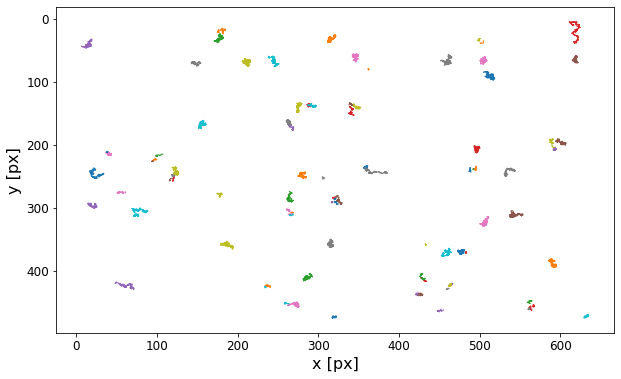

In [60]:
plot = tp.plot_traj(tracks_filtered) #plot the resultant tracks
#save this plot
fig = plot.get_figure()
fig.savefig(res_dir+'trajectories_test.pdf')

## Save the Data

We have already shown a few examples of how to save files and keep the organised in a 'results' folder. You can save the tracks dataframe as a single CSV file as follows. A CSV (comma separated values) file is a simple text file that can be imported by many programs (eg, Excel) and can also be viewed in any text editor.

In [61]:
#write to .csv file
tracks_filtered.to_csv(res_dir+'track_filtered_test.csv', sep=",") 

#show the first few lines of the tracks dataframe
tracks_filtered.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,245.644306,33.637025,343.238469,1.881569,0.128222,21.775920,5468.0,0.043764,0,1
0,246.645369,283.209452,472.109074,1.893976,0.050598,29.629530,5566.0,0.037844,0,2
0,274.409258,264.277498,778.935350,2.206824,0.077910,35.876720,6278.0,0.019087,0,5
0,283.787511,317.858139,588.842282,1.855413,0.076327,39.446543,5736.0,0.030652,0,6
0,299.128282,24.919451,897.453469,2.252639,0.065495,35.341246,6573.0,0.015835,0,7


In [62]:
#read in a previously saved dataframe
tracks_old = pd.read_csv(res_dir+'track_filtered_test.csv', index_col=0) 

tracks_old = tracks_old.rename(columns={"frame.1": "frame"}) #for some reason the frames col gets renamed - fix this

tracks_old.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,245.644306,33.637025,343.238469,1.881569,0.128222,21.775920,5468.0,0.043764,0,1
0,246.645369,283.209452,472.109074,1.893976,0.050598,29.629530,5566.0,0.037844,0,2
0,274.409258,264.277498,778.935350,2.206824,0.077910,35.876720,6278.0,0.019087,0,5
0,283.787511,317.858139,588.842282,1.855413,0.076327,39.446543,5736.0,0.030652,0,6
0,299.128282,24.919451,897.453469,2.252639,0.065495,35.341246,6573.0,0.015835,0,7


# Calibration 
For your further data analysis, you will need to know the frame rate (number of pictures the camera takes per second (fps)) and also how pixels in the images translate into actual distances (in μm). The latter can be measured by taking a picture of a microscopic ruler (calibration slide) with the microscope you are using (ask for help here). 

# Further analysis
We provide some simple python tools to use in your analysis (since we want you to focus on the physics, not programming). These include a simple routine to compute the mean square displacement $\langle \Delta R_i^2(t) \rangle_i$ of your particles (no promises that this is the best way to do this), as well as some dataframe manipulation techniques to get displacement distributions for a given lag time (either for a specific particles or all of them). We also show show examples of saving graphs/text data (you can keep editing/adding to this notebook, or work with software of your choice for making your final plots, fits etc).




### Mean squared displacement

The code snippet below computes the mean squared displacement for each track relative to each particles initial position, and then averages over all particles (is there anything special about the initial position?). If there are gaps in the tracks, it interpolates between positions so that there are the same number of data points for each time step (is this a good idea?).  Since we can't interpolate past the end of track, we throw out any tracks that are shorter than `min_len`, so this means there is a trade off between plotting this msd over longer times, and averaging over more particles. In the 2nd cell, we show how to plot and save this data as a text file.

In [63]:
# Declare the pixel and time calibrations 
x40_calib = 50 * 10**(-6)/155
x100_calib = 50 * 10**(-6)/350
fps_convert = 22.8

# Declare all the other constants
viscosity = 9.5 * 10**(-4)
T = 295
k_B = 1.38 * 10**(-23)

In [64]:
min_len = 100;
tracks_filtered_msd = tp.filter_stubs(tracks, min_len )

time = np.linspace(1,min_len,num=min_len) # array of timesteps (haven't scaled to real units yet)
dr2 = 0.0*time; # empty array for msd, same size as time array
dx2 = dr2;  dy2 = dr2; # in case I decide I want to look at x and y msd separately

#simple msd (computes disp relative to starting point)
particle_ids = set(tracks_filtered_msd['particle'])   # get a set (list) of particle ids w/o duplicates
ntr = tracks_filtered_msd['particle'].nunique();
print('Using  ', ntr, ' tracks')

for id in particle_ids:
    t = tracks_filtered_msd[tracks_filtered_msd['particle']==id]
    f_arr = t['frame'].to_numpy(); #numpy array for time (frames)
    x_arr = t['x'].to_numpy(); y_arr = t['y'].to_numpy(); #numpy arrays of x and y coord
    x_arr = x_arr-x_arr[0]; y_arr = y_arr-y_arr[0]; #positions relative to starting point
    f_arr = f_arr - f_arr[0]
    #linear interpolate to fill gaps, also removes t=0 point
    x_inter = np.interp(time,f_arr,x_arr); y_inter = np.interp(time,f_arr,y_arr); 
    dx2 = dx2+x_inter**2; dy2 = dy2+y_inter**2; 
    dr2 = dr2+x_inter**2+y_inter**2;
    
dx2 = dx2/ntr; dy2 = dy2/ntr; dr2 = dr2/ntr;
dx2 = dx2 * x40_calib**2
dy2 = dy2 * x40_calib**2
dr2 = dr2 * x40_calib**2
time = time / fps_convert    
    


Using   39  tracks


In [65]:
# Fit a straight line for the data below
def find_line(x,A):
    return A*x

In [66]:
# Work out the gradient of the slope and the correspondent radius of the particle
import scipy

popt, pcov = scipy.optimize.curve_fit(find_line, time, dr2, sigma=None, p0=0.25 * 10**(-12))
print("The estimated gradient of the slope is: " + str(popt))

print("The Diffusion Coefficient is: " + str(popt/4))

a = (k_B * T) / (6 * np.pi * viscosity * (popt/4))
print("The estimated radius of the milk particle is: " + str(a) + " meters")

The estimated gradient of the slope is: [1.38089334e-12]
The Diffusion Coefficient is: [3.45223334e-13]
The estimated radius of the milk particle is: [6.58531011e-07] meters


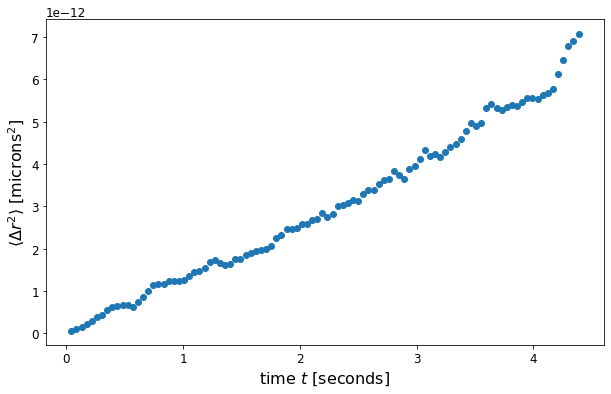

In [67]:
fig, ax = plt.subplots()
ax.plot(time, dr2, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
#could rescale distance and time once calibration done...
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [microns$^2$]',
       xlabel='time $t$ [seconds]')  

#save the plot
fig.savefig(res_dir+'msd_test.pdf')
#save txt data
np.savetxt(res_dir+'msd_test.csv', np.column_stack((time, dr2, dx2, dy2)), 
           delimiter=",", header="time,dr2,dx2,dy2", comments = '');

The code snippets below compute the distribution of displacements for a given lag time $\Delta t$ (in this case we start with a 1 frame lag), ie $\Delta x(t_i,\Delta t)=x(t_i)-x(t_i+\Delta t)$. In the first example we get the full distribution for all the particles, in the second we pick out a single particle 

In [68]:
# Fit the curve below into a gaussian
def my_gaussian(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2*sig**2))

The estimated gaussian for the x-displacement is: 1.7832971035636724e-07 meters
The diffusion coefficient in this case is: 3.625369357919585e-13
The estimated radius of the milk particle is: 6.270816816118928e-07 meters


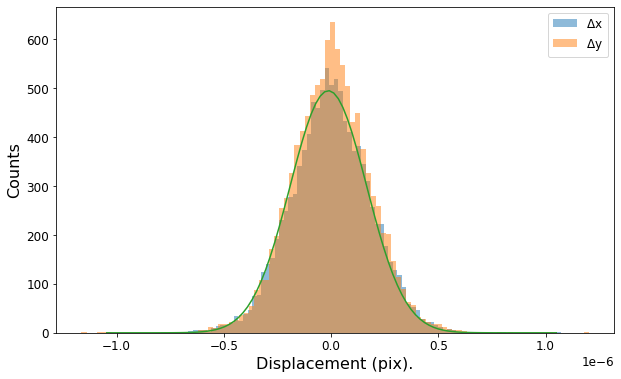

In [69]:
t_lag = 1;
    
#pandas magic to order the x and y positions by frame number and particle id
px = tracks_filtered.set_index(['frame', 'particle'])['x'].unstack()
px = px.reindex(np.arange(px.index[0], 1 + px.index[-1]))
py = tracks_filtered.set_index(['frame', 'particle'])['y'].unstack()
py = py.reindex(np.arange(py.index[0], 1 + py.index[-1]))
    
#again using pandas to compute the difference between positions as a given time lag (in frames)
#the .shift and .sub are shift and subtraction operations, respectively
dispx = px.sub(px.shift(t_lag)); dispy = py.sub(py.shift(t_lag));
    
#this puts entries from individual particles into one big array 
dispx = dispx.values.flatten(); dispy = dispy.values.flatten();
    
dispx = dispx[np.isfinite(dispx)]; dispy = dispy[np.isfinite(dispy)];#remove nans due to gaps in tracks

# Calibrate the displacements
dispx = dispx * x40_calib
dispy = dispy * x40_calib
    
dx_count, dx_bins = np.histogram(dispx, bins=100); #compute the histograms
dy_count, dy_bins = np.histogram(dispy, bins=100); 

popt, pcov = scipy.optimize.curve_fit(my_gaussian, dx_bins[:-1], dx_count, sigma=None, p0=np.array([0.05, 0, 10**(-6)]))
    
fig, ax = plt.subplots()    
ax.hist(dispx, bins = dx_bins, alpha=0.5, label=r'$\Delta$x');
ax.hist(dispy, bins = dy_bins, alpha=0.5, label=r'$\Delta$y');
ax.set(xlabel='Displacement (pix).', ylabel='Counts' )

ax.legend(loc='best');

print("The estimated gaussian for the x-displacement is: " + str(popt[2]) + " meters")

# print the equivalent diffusion coefficient
D = (popt[2])**2 * fps_convert / 2
print("The diffusion coefficient in this case is: " + str(D))

a = (k_B * T) / (6 * np.pi * viscosity * D)
print("The estimated radius of the milk particle is: " + str(a) + " meters")

# plot the resulted curve
plt.plot(dx_bins[:-1], my_gaussian(dx_bins[:-1], popt[0], popt[1], popt[2]))
plt.show()
#save stuff

fig.savefig(res_dir+'displacements_all_tlag_'+str(t_lag)+'.pdf')

99
The estimated gaussian width is: 1.8815222751101983e-07
The diffusion coefficient in this case is: 4.0357437217788767e-13
The estimated radius of the milk particle is: 5.633169175634299e-07 meters


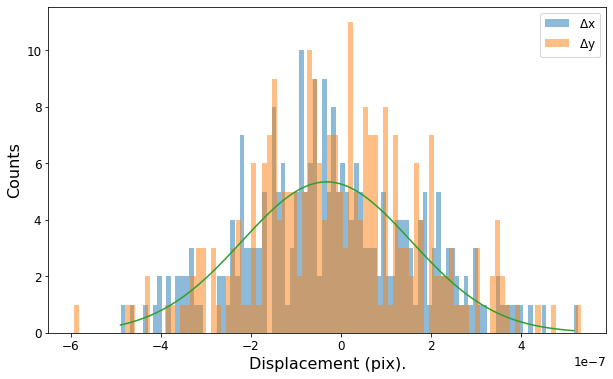

In [70]:
t_lag = 1;
part_ind =0; #the zero could be any number < len(ids)

#can also get distributions for a specific particle
ids = list(set(tracks_filtered['particle']))
print(len(ids))
t = tracks_filtered[tracks_filtered['particle']==ids[part_ind]] 
    
#same routine as before
px = t.set_index(['frame', 'particle'])['x'].unstack()
px = px.reindex(np.arange(px.index[0], 1 + px.index[-1]))
py = t.set_index(['frame', 'particle'])['y'].unstack()
py = py.reindex(np.arange(py.index[0], 1 + py.index[-1]))
    
dispx = px.sub(px.shift(t_lag)); dispy = py.sub(py.shift(t_lag));
    
dispx = dispx.values.flatten(); dispy = dispy.values.flatten();
    
dispx = dispx[np.isfinite(dispx)]; dispy = dispy[np.isfinite(dispy)];#remove nans due to gaps in tracks

# Make the required calibrations
dispx = dispx * x40_calib
dispy = dispy * x40_calib
    
dx_count, dx_bins = np.histogram(dispx, bins=100); #compute the histograms
dy_count, dy_bins = np.histogram(dispy, bins=100); 
  
# Fit the gaussian again    
popt, pcov = scipy.optimize.curve_fit(my_gaussian, dx_bins[:-1], dx_count, sigma=None, p0=np.array([8, 0, 10**(-7)])) 

# print the estimated gaussian
print("The estimated gaussian width is: " + str(popt[2]))

# print the equivalent diffusion coefficient
D = (popt[2])**2 * fps_convert / 2
print("The diffusion coefficient in this case is: " + str(D))

# print the radius of the milk particle
a = (k_B * T) / (6 * np.pi * viscosity * D)
print("The estimated radius of the milk particle is: " + str(a) + " meters")
    
fig, ax = plt.subplots()    
ax.hist(dispx, bins = dx_bins, alpha=0.5, label=r'$\Delta$x');
ax.hist(dispy, bins = dy_bins, alpha=0.5, label=r'$\Delta$y');

# plot the resulted curve
plt.plot(dx_bins[:-1], my_gaussian(dx_bins[:-1], popt[0], popt[1], popt[2]))

ax.set(xlabel='Displacement (pix).', ylabel='Counts' )

ax.legend(loc='best');

#make a sub-directory to store all this
part_disp_dir = res_dir+'part_displacements'+os.sep;
if not os.path.exists(part_disp_dir):
    os.mkdir(part_disp_dir)

fig.savefig(part_disp_dir+'displacements_tlag_'+str(t_lag)+'_part_'+str(ids[part_ind])+'.pdf')

It is also possible to plot trajectories for individual particles.

[Text(0, 0.5, 'x [pix.]'), Text(0.5, 0, 'y [pix.]')]

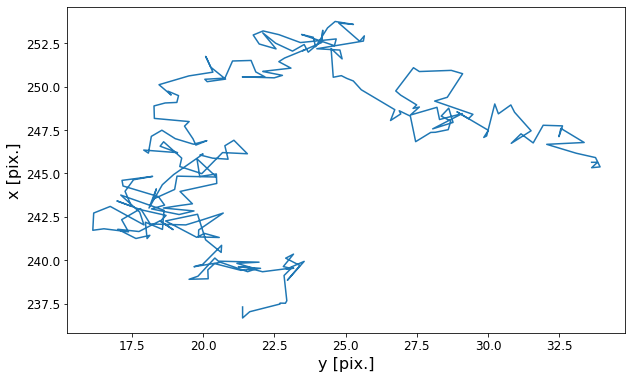

In [71]:
ids = list(set(tracks_filtered['particle']))
t = tracks_filtered[tracks_filtered['particle']==ids[0]]

fig, ax = plt.subplots()
ax.plot(t.x,t.y)
ax.set(ylabel='x [pix.]',
       xlabel='y [pix.]') 

## Odds and ends
`tp.locate`  actually does two things all in one step: first it preprocesses them to remove both noise and large-scale intensity variations, then it looks for peaks in these cleaned up images. It can sometimes be helpful to look at these processed images, since this is what `tp.locate` actually works with to find your particles. Knowing this might be helpful when trying to optimise your locating / filtering parameters.

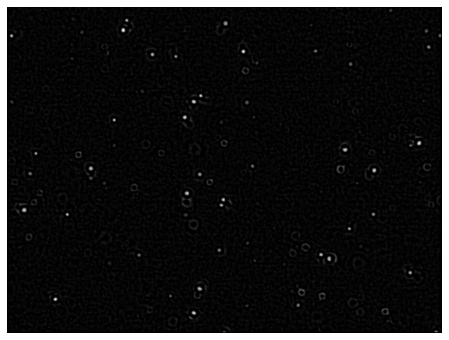

In [72]:
proc_frame = tp.bandpass(255-newframes[0],1,9, threshold =0) 
#2^8 - 1 =255 max intensity for 8-bit greyscale image, 255-image = inverted_image
#the 1 is the scale of the pixel level noise, in almost all cases no reason to change this
#the 9 is the estimate for the particle size we used above. here is sets the smoothing window
#threshold parameter works the same as above, here you can better see what you are cutting out (play around)
plt.imshow(proc_frame); plt.axis('off');

for example, we can see that we are getting some 'halos' around certain particles (mostly the light ones), which could get mistakenly picked up as particle centers. 